### Research
In well log lithology interpretation, the phrase "building a proper algorithm to map stringers" refers to the process of developing a systematic and accurate method to identify and characterize stringers within the geological formations encountered in a well.

Stringers typically refer to thin, elongated or discontinuous layers or veins of a specific lithology (rock type) within a larger formation. These stringers may have distinct properties or lithologies compared to the surrounding rock units, and identifying and mapping them accurately is important for understanding the geological characteristics of the subsurface.

To "build a proper algorithm" means creating a set of rules or procedures that can be applied to well log data to identify and delineate stringers. This algorithm should leverage the information provided by different well log measurements, such as gamma ray, resistivity, density, neutron porosity, etc., to detect and classify stringers based on their unique signatures.

The algorithm may involve analyzing patterns and anomalies in the well log data, using statistical methods, applying machine learning techniques, or incorporating domain-specific knowledge. The goal is to create a reliable and consistent approach that can be applied across multiple wells or sections of a well to accurately identify and map stringers in the subsurface.

By developing such an algorithm, geoscientists and reservoir engineers can gain insights into the distribution and characteristics of stringers, which can have implications for hydrocarbon reservoir quality, fluid flow behavior, and overall geological modeling and interpretation.

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [2]:
def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])
        
    return data

In [3]:
def fill_missing_values(df):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(df.columns)
    for _ in cols:

        df[_] = np.where(df[_] == np.inf, -999, df[_])
        df[_] = np.where(df[_] == np.nan, -999, df[_])
        df[_] = np.where(df[_] == -np.inf, -999, df[_])
        
    return df


In [19]:
PWD = '/media/Data-B/my_research/Geoscience_FL/data_well_log/'

A = np.load('penalty_matrix.npy')
train = pd.read_csv(PWD + 'train.csv', sep=';')
test = pd.read_csv(PWD + 'test.csv', sep=';')
hidden_test = pd.read_csv(PWD + 'hidden_test.csv', sep=';')

The augment_features_window function is used to concatenate feature windows in a given dataset. It takes two inputs: X, which is the input feature matrix, and N_neig, representing the number of neighboring windows to consider on each side of the current window. The function performs the following steps:

In [20]:
#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl


# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [21]:
def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

In [32]:
class Model():

    '''
    class to lithology prediction
    '''
    
    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''
        
        self.train = train
        self.test = test

        
    def __call__(self, plot = True, save_file = True):

      return self.fit(plot, save_file)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
        
        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values
        
        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values  
        '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''

        

        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = df.drop(cols, axis=1)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)
        
        df = df.fillna(-999)
        df = process(df)
        data = df.copy()
        
        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        
        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')
 
        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)
        
        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')
    
        return traindata1, testdata1, lithology1, lithology_numbers

    
    def fit(self, plot, save_file):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      open_test = np.zeros((len(testdata1), 12))
      
      #100 n-estimators and 10 max-depth
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500)
      
 
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]
    
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        open_test += model.predict_proba(pd.DataFrame(testdata1))
      
      open_test= pd.DataFrame(open_test/split)
    
      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')

                  
      if plot: self.plot_feat_imp(model)

      if save_file: 
        category_to_lithology = {y:x for x,y in lithology_numbers.items()}
        test_prediction = np.vectorize(category_to_lithology.get)(open_test)
        np.savetxt(PWD + 'saved_test.csv', test_prediction, header='lithology', fmt='%i')
        print(f'Test file was saved at {PWD}')

      return open_test, model, lithology_numbers
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
      


shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:40:12] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16257
[99]	validation_0-mlogloss:0.31878
Default score: [-0.27601301]
Accuracy is: 0.8954481768786522
F1 is: 0.8993384185369895
None
-----------------------FOLD 1---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:40:43] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16181
[99]	validation_0-mlogloss:0.31853
Default score: [-0.27763325]
Accuracy is: 0.8944989790774961
F1 is: 0.8983172995034832
None
-----------------------FOLD 2---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:41:14] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16218
[99]	validation_0-mlogloss:0.31776
Default score: [-0.27616381]
Accuracy is: 0.894780907467685
F1 is: 0.8987179702065834
None
-----------------------FOLD 3---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:41:44] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16176
[99]	validation_0-mlogloss:0.31721
Default score: [-0.27724347]
Accuracy is: 0.8946100417766615
F1 is: 0.8985731199811154
None
-----------------------FOLD 4---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:42:15] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16174
[99]	validation_0-mlogloss:0.31610
Default score: [-0.27232574]
Accuracy is: 0.8960367702967083
F1 is: 0.8997867913066475
None
-----------------------FOLD 5---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:42:46] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16231
[99]	validation_0-mlogloss:0.32016
Default score: [-0.27816401]
Accuracy is: 0.894396459662882
F1 is: 0.8984114375721077
None
-----------------------FOLD 6---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:43:17] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16162
[99]	validation_0-mlogloss:0.31790
Default score: [-0.27629409]
Accuracy is: 0.894874883597748
F1 is: 0.8988063631934639
None
-----------------------FOLD 7---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:43:48] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16190
[99]	validation_0-mlogloss:0.31552
Default score: [-0.27449573]
Accuracy is: 0.8958829911747871
F1 is: 0.8997673168120687
None
-----------------------FOLD 8---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:44:19] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16204
[99]	validation_0-mlogloss:0.31849
Default score: [-0.27701814]
Accuracy is: 0.8948492537440944
F1 is: 0.8988360121438612
None
-----------------------FOLD 9---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:44:50] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16239
[99]	validation_0-mlogloss:0.32290
Default score: [-0.28474127]
Accuracy is: 0.8919957967040009
F1 is: 0.8958727911863027
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------
Test file was saved


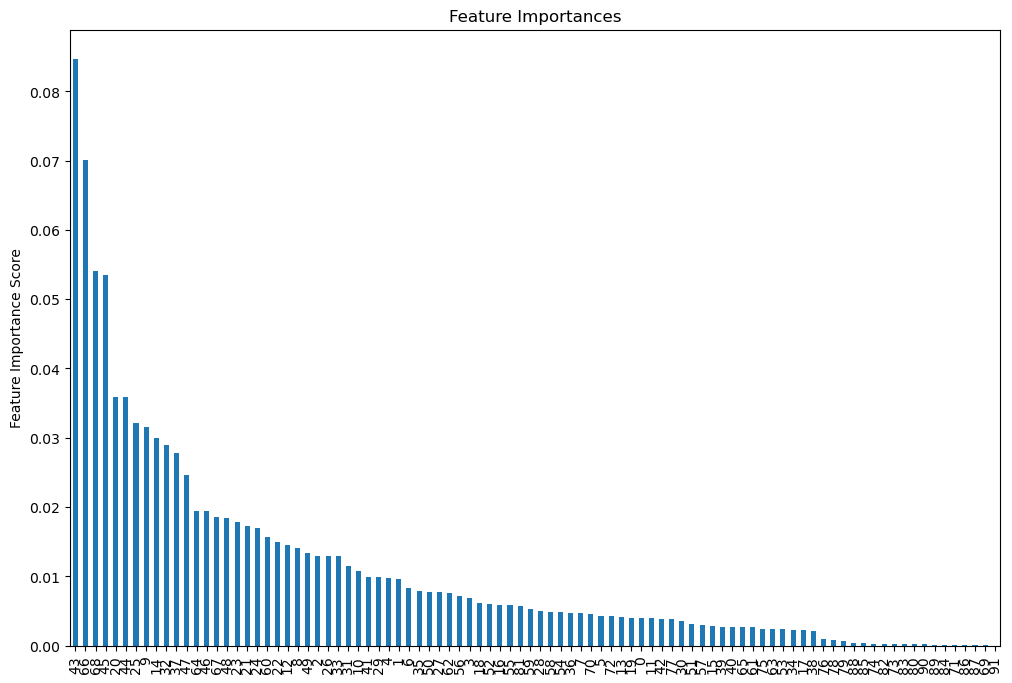

In [29]:
#To train model and make prediction
func_= Model(train, test)
prediction, model, redundant = func_()

In [30]:
# Prediction of the model above
prediction

array([2, 2, 2, ..., 0, 1, 1])

In [31]:
pred_df = pd.read_csv(f'{PWD}saved_test.csv')
pred_df['# lithology'].value_counts()

65000    96936
30000    23746
65030     9194
70000     5037
99000      978
80000      483
90000      397
86000       15
Name: # lithology, dtype: int64

In [35]:
PWD = '/media/Data-B/my_research/Geoscience_FL/data_well_log/'

A = np.load('penalty_matrix.npy')
train = pd.read_csv(PWD + 'train.csv', sep=';')
test = pd.read_csv(PWD + 'test.csv', sep=';')
hidden_test = pd.read_csv(PWD + 'hidden_test.csv', sep=';')

shape of concatenated dataframe before dropping columns (1292908, 29)
shape of dataframe after dropping columns (1292908, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1292908, 27)
Splitting concatenated dataframe into training and test datasets...
(1292908, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (122397, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (122397, 92))


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:49:44] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16220
[99]	validation_0-mlogloss:0.31827
Default score: [-0.27675841]
Accuracy is: 0.8947988927997813
F1 is: 0.8987229275519424
None
-----------------------FOLD 1---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:50:15] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16224
[99]	validation_0-mlogloss:0.31595
Default score: [-0.27532443]
Accuracy is: 0.8953447642480629
F1 is: 0.8990070887543582
None
-----------------------FOLD 2---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:50:46] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16140
[99]	validation_0-mlogloss:0.31615
Default score: [-0.27439215]
Accuracy is: 0.8954643702317793
F1 is: 0.8992083730609859
None
-----------------------FOLD 3---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:51:17] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16225
[99]	validation_0-mlogloss:0.31925
Default score: [-0.27939744]
Accuracy is: 0.8940889014190395
F1 is: 0.8980117872761183
None
-----------------------FOLD 4---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16195
[99]	validation_0-mlogloss:0.31952
Default score: [-0.27656214]
Accuracy is: 0.8949859462969133
F1 is: 0.8989819923607889
None
-----------------------FOLD 5---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:52:19] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16204
[99]	validation_0-mlogloss:0.31868
Default score: [-0.28012683]
Accuracy is: 0.8937471700369924
F1 is: 0.897780959783587
None
-----------------------FOLD 6---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:52:50] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16186
[99]	validation_0-mlogloss:0.31793
Default score: [-0.27662835]
Accuracy is: 0.894584411923008
F1 is: 0.8986586344422488
None
-----------------------FOLD 7---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:53:21] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16159
[99]	validation_0-mlogloss:0.31625
Default score: [-0.27510444]
Accuracy is: 0.8956608657764564
F1 is: 0.8995360747491613
None
-----------------------FOLD 8---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:53:52] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16209
[99]	validation_0-mlogloss:0.31837
Default score: [-0.27827934]
Accuracy is: 0.8943708298092284
F1 is: 0.8981775029472532
None
-----------------------FOLD 9---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16222
[99]	validation_0-mlogloss:0.31965
Default score: [-0.27605702]
Accuracy is: 0.8948407104595433
F1 is: 0.8987118582292674
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------
Test file was saved at /media/Data-B/my_research/Geoscience_FL/data_well_log/


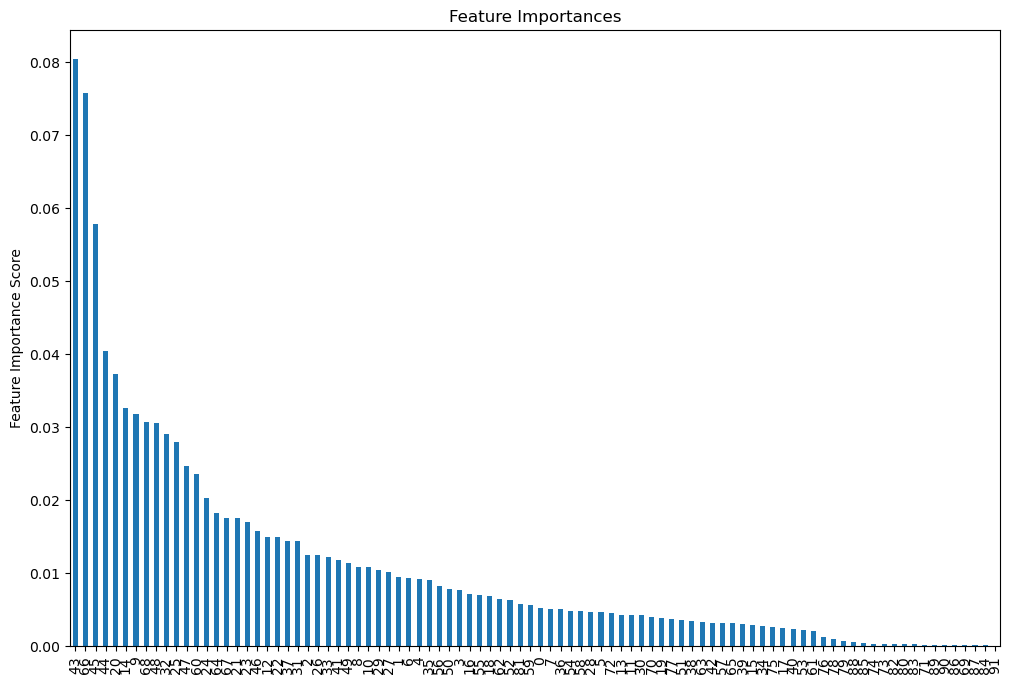

In [36]:
run_hidden_test = Model(train, hidden_test)
prediction, model, redundant = run_hidden_test()